# Data Science in Practice 2020

## Problem Set 2

### Descriptive report

Authors :
- Rayan Chaouche
- Yann Martinson
- Christopher Padovani
- Jules Triomphe

### 1. Initialization

Loading modules :

In [22]:

!python -m pip install pandoc

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Program Files\Python37\lib\site-packages\pip\_internal\cli\base_command.py", line 186, in _main
    status = self.run(options, args)
  File "C:\Program Files\Python37\lib\site-packages\pip\_internal\commands\install.py", line 258, in run
    isolated_mode=options.isolated_mode,
  File "C:\Program Files\Python37\lib\site-packages\pip\_internal\commands\install.py", line 604, in decide_user_install
    if site_packages_writable(root=root_path, isolated=isolated_mode):
  File "C:\Program Files\Python37\lib\site-packages\pip\_internal\commands\install.py", line 549, in site_packages_writable
    test_writable_dir(d) for d in set(get_lib_location_guesses(**kwargs))
  File "C:\Program Files\Python37\lib\site-packages\pip\_internal\commands\install.py", line 549, in <genexpr>
    test_writable_dir(d) for d in set(get_lib_location_guesses(**kwargs))
  File "C:\Program Files\Python37\lib\site-packages\pip\_internal\utils\filesystem

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from operator import itemgetter, attrgetter
from scipy.stats import randint as sp_randint

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import log_loss, classification_report, confusion_matrix, roc_curve, accuracy_score, roc_auc_score, precision_recall_fscore_support, precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.preprocessing import StandardScaler

# import time

from matplotlib import pyplot as plt

Defining functions :

In [2]:
def df_pp() :

    df_raw = pd.read_csv('customers.csv')
    
    # clean up lines
    
    total_length = len(df_raw)
    df_raw = df_raw[df_raw['TotalCharges'] != ' ']
    df_raw.TotalCharges = df_raw.TotalCharges.astype('float')
    cleanup_length = len(df_raw)
    print('%s lines were deleted.' %(total_length - cleanup_length))
    
    # output into dummies
    
    churn_dummy_dict = {'Yes': 1, 'No': 0}
    df_raw.Churn.replace(churn_dummy_dict, inplace = True)
    
    # X y splitting
    
    y = df_raw.Churn.copy()
    X_raw = df_raw.drop(columns ='Churn').copy()
    
    # input into dummies
    
    X_raw_types = dict(X_raw.dtypes)
    features = list(X_raw.columns)
    categorical_features = [feat for feat in features if X_raw_types[feat] == 'O']
    categorical_features.remove('customerID')
    
    X = pd.get_dummies(X_raw, columns = categorical_features,prefix_sep=':')
    X = X.drop(columns = 'customerID').copy()

    return df_raw,categorical_features, X, y, cleanup_length

In [3]:
def df_preprocessing_knn() :

    df_raw,categorical_features, X, y, _ = df_pp()
    
    # train val splitting

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

    y_train = y_train.tolist()
    y_test = y_test.tolist()

    return df_raw,categorical_features, X, X_train, X_test, y, y_train, y_test

In [4]:
def df_preprocessing_rf(test_size) :
    
    df_raw,categorical_features, X, y, cleanup_length = df_pp()
    
    # train val splitting

    train = np.random.rand(cleanup_length)> test_size

    X_train = X[train]
    X_test = X[~train]

    y_train = y[train].tolist()
    y_test = y[~train].tolist()

    return df_raw,categorical_features, X, X_train, X_test, y, y_train, y_test

In [5]:
def plot_importance(feature_importance_sorted, n, type_of_search):
    
    plt.figure(figsize=(15,5))
    x = np.arange(n)
    y = [feature_importance_sorted[i][1] for i in range(n)]
    labels = [feature_importance_sorted[i][0] for i in range(n)]
    ax = sns.barplot(y,x,orient="h");
    plt.xlabel("Importance fraction", fontsize = 12)
    ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    plt.yticks(x,labels, fontsize = 15)
    plt.title('Most important feature: {}'.format(type_of_search), fontsize = 15)
    plt.show()

### 2. K-Nearest Neighbors Classifier

We start by scaling the data.

In [6]:
df_raw,categorical_features, X, X_train, X_test, y, y_train, y_test = df_preprocessing_knn()

11 lines were deleted.


In [7]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

We run simulations for k-values between 1 and 100 to find the best fit parameters.

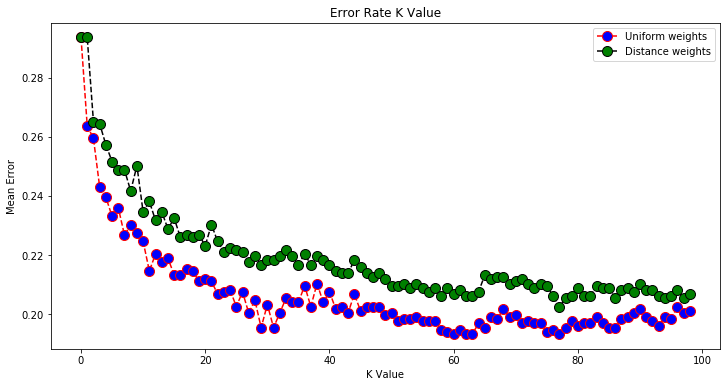

Minimum error rate with uniform weights: 19.33% for k = 61
Minimum error rate with distance weights: 20.26% for k = 78


In [8]:
error_uni = np.array([0])
error_dist = np.array([0])

for i in range(1, 100):
    knn_uni = KNeighborsClassifier(n_neighbors=i, weights='uniform')
    knn_uni.fit(X_train, y_train)
    pred_i_uni = knn_uni.predict(X_test)
    error_uni = np.append(error_uni, np.array(np.mean(pred_i_uni != y_test)))

    knn_dist = KNeighborsClassifier(n_neighbors=i, weights='distance')
    knn_dist.fit(X_train, y_train)
    pred_i_dist = knn_dist.predict(X_test)
    error_dist = np.append(error_dist, np.array(np.mean(pred_i_dist != y_test)))


plt.figure(figsize=(12, 6))
plt.plot(error_uni[1:], color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10, label='Uniform weights')
plt.plot(error_dist[1:], color='black', linestyle='dashed', marker='o', markerfacecolor='green', markersize=10, label='Distance weights')
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.legend(loc='best')
plt.show()

print('Minimum error rate with uniform weights: {:.2%} for k = {}'.format(min(error_uni[1:]), np.argmin(error_uni[1:]) + 1))
print('Minimum error rate with distance weights: {:.2%} for k = {}'.format(min(error_dist[1:]), np.argmin(error_dist[1:]) + 1))

In [9]:
classifier_uni = KNeighborsClassifier(n_neighbors = (np.argmin(error_uni[1:]) + 1), weights='uniform')
classifier_uni.fit(X_train, y_train)
classifier_dist = KNeighborsClassifier(n_neighbors = (np.argmin(error_dist[1:]) + 1), weights='distance')
classifier_dist.fit(X_train, y_train)

y_pred_uni = classifier_uni.predict(X_test)
y_pred_dist = classifier_dist.predict(X_test)

UNIFORM WEIGHTS
Accuracy: 80.67%
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1029
           1       0.65      0.59      0.62       378

    accuracy                           0.81      1407
   macro avg       0.76      0.74      0.75      1407
weighted avg       0.80      0.81      0.80      1407



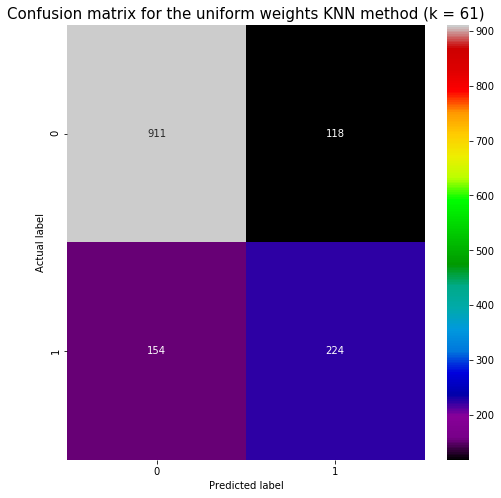

In [10]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test, y_pred_uni), annot=True, fmt="d", cmap="nipy_spectral")
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion matrix for the uniform weights KNN method (k = {})'.format(np.argmin(error_uni[1:]) + 1), fontsize = 15);
print("UNIFORM WEIGHTS")
print("Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred_uni)))
print(classification_report(y_test, y_pred_uni))

DISTANCE WEIGHTS
Accuracy: 79.74%
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1029
           1       0.64      0.56      0.60       378

    accuracy                           0.80      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.79      0.80      0.79      1407



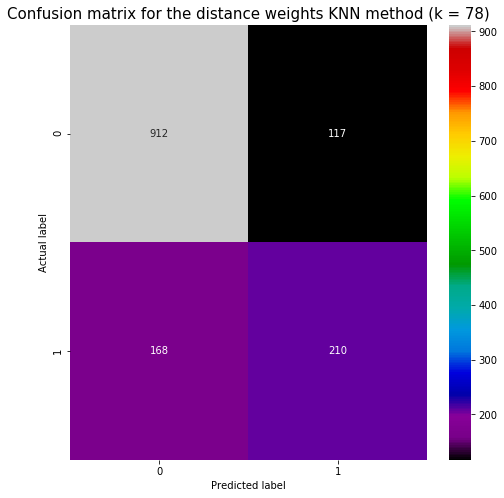

In [11]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test, y_pred_dist), annot=True, fmt="d", cmap="nipy_spectral")
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion matrix for the distance weights KNN method (k = {})'.format(np.argmin(error_dist[1:]) + 1), fontsize = 15);
print("DISTANCE WEIGHTS")
print("Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred_dist)))
print(classification_report(y_test, y_pred_dist))

### 3. Random Forest Classifier

We will compare two methods, which are grid search and random search.

In [12]:
df_raw,categorical_features, X, X_train, X_test, y, y_train, y_test = df_preprocessing_rf(0.3)

11 lines were deleted.


In [13]:
clf = RandomForestClassifier(n_jobs=-1)

#### 3.1 Grid search

To avoid having too high a computational time, we will focus on 2 of the mot important parameters that are max depth and the number of estimators.

##### Max Depth
This parameter is the depth of the trees, which is one of the most important. We range it between 4 (anything lower seems too low and imcreases computational time without much results) and 15.

##### Number of estimators
This parameter is the number of trees that are going to be generated. Here the choice of the number of trees will mostly affect the computational time. Let's set the values between 10 and 500 and see the effects.

In [14]:
max_depth = list(range(4,16))

In [15]:
n_estimators = [10, 15, 20, 50, 100, 200, 500]

Let's use the default 5 folds of cross validation.

In [16]:
grid_parameters = {'max_depth' : max_depth, 'n_estimators' : n_estimators }

In [17]:
grid_clf = GridSearchCV(clf, param_grid = grid_parameters, verbose = 3)

In [18]:
grid_clf.fit(X_train, y_train)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] max_depth=4, n_estimators=10 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ max_depth=4, n_estimators=10, score=0.799, total=   6.6s
[CV] max_depth=4, n_estimators=10 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


[CV] ........ max_depth=4, n_estimators=10, score=0.811, total=   0.2s
[CV] max_depth=4, n_estimators=10 ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.8s remaining:    0.0s


[CV] ........ max_depth=4, n_estimators=10, score=0.787, total=   0.3s
[CV] max_depth=4, n_estimators=10 ....................................
[CV] ........ max_depth=4, n_estimators=10, score=0.782, total=   0.2s
[CV] max_depth=4, n_estimators=10 ....................................
[CV] ........ max_depth=4, n_estimators=10, score=0.793, total=   0.2s
[CV] max_depth=4, n_estimators=15 ....................................
[CV] ........ max_depth=4, n_estimators=15, score=0.803, total=   0.3s
[CV] max_depth=4, n_estimators=15 ....................................
[CV] ........ max_depth=4, n_estimators=15, score=0.814, total=   0.2s
[CV] max_depth=4, n_estimators=15 ....................................
[CV] ........ max_depth=4, n_estimators=15, score=0.785, total=   0.2s
[CV] max_depth=4, n_estimators=15 ....................................
[CV] ........ max_depth=4, n_estimators=15, score=0.789, total=   0.3s
[CV] max_depth=4, n_estimators=15 ....................................
[CV] .

[CV] ....... max_depth=5, n_estimators=200, score=0.807, total=   1.4s
[CV] max_depth=5, n_estimators=200 ...................................
[CV] ....... max_depth=5, n_estimators=200, score=0.810, total=   1.2s
[CV] max_depth=5, n_estimators=200 ...................................
[CV] ....... max_depth=5, n_estimators=200, score=0.787, total=   1.5s
[CV] max_depth=5, n_estimators=200 ...................................
[CV] ....... max_depth=5, n_estimators=200, score=0.786, total=   1.5s
[CV] max_depth=5, n_estimators=200 ...................................
[CV] ....... max_depth=5, n_estimators=200, score=0.794, total=   1.5s
[CV] max_depth=5, n_estimators=500 ...................................
[CV] ....... max_depth=5, n_estimators=500, score=0.809, total=   4.0s
[CV] max_depth=5, n_estimators=500 ...................................
[CV] ....... max_depth=5, n_estimators=500, score=0.810, total=   3.7s
[CV] max_depth=5, n_estimators=500 ...................................
[CV] .

[CV] ........ max_depth=7, n_estimators=20, score=0.792, total=   0.3s
[CV] max_depth=7, n_estimators=20 ....................................
[CV] ........ max_depth=7, n_estimators=20, score=0.788, total=   0.3s
[CV] max_depth=7, n_estimators=50 ....................................
[CV] ........ max_depth=7, n_estimators=50, score=0.805, total=   0.5s
[CV] max_depth=7, n_estimators=50 ....................................
[CV] ........ max_depth=7, n_estimators=50, score=0.821, total=   0.5s
[CV] max_depth=7, n_estimators=50 ....................................
[CV] ........ max_depth=7, n_estimators=50, score=0.790, total=   0.5s
[CV] max_depth=7, n_estimators=50 ....................................
[CV] ........ max_depth=7, n_estimators=50, score=0.793, total=   0.6s
[CV] max_depth=7, n_estimators=50 ....................................
[CV] ........ max_depth=7, n_estimators=50, score=0.788, total=   0.5s
[CV] max_depth=7, n_estimators=100 ...................................
[CV] .

[CV] ........ max_depth=9, n_estimators=10, score=0.807, total=   0.2s
[CV] max_depth=9, n_estimators=10 ....................................
[CV] ........ max_depth=9, n_estimators=10, score=0.776, total=   0.3s
[CV] max_depth=9, n_estimators=10 ....................................
[CV] ........ max_depth=9, n_estimators=10, score=0.790, total=   0.2s
[CV] max_depth=9, n_estimators=10 ....................................
[CV] ........ max_depth=9, n_estimators=10, score=0.798, total=   0.2s
[CV] max_depth=9, n_estimators=15 ....................................
[CV] ........ max_depth=9, n_estimators=15, score=0.809, total=   0.3s
[CV] max_depth=9, n_estimators=15 ....................................
[CV] ........ max_depth=9, n_estimators=15, score=0.814, total=   0.3s
[CV] max_depth=9, n_estimators=15 ....................................
[CV] ........ max_depth=9, n_estimators=15, score=0.792, total=   0.3s
[CV] max_depth=9, n_estimators=15 ....................................
[CV] .

[CV] ...... max_depth=10, n_estimators=100, score=0.794, total=   1.0s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.822, total=   2.0s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.825, total=   2.0s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.782, total=   1.9s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.791, total=   2.4s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.791, total=   2.3s
[CV] max_depth=10, n_estimators=500 ..................................
[CV] ...... max_depth=10, n_estimators=500, score=0.814, total=   5.4s
[CV] max_depth=10, n_estimators=500 ..................................
[CV] .

[CV] ....... max_depth=12, n_estimators=20, score=0.775, total=   0.5s
[CV] max_depth=12, n_estimators=20 ...................................
[CV] ....... max_depth=12, n_estimators=20, score=0.791, total=   0.3s
[CV] max_depth=12, n_estimators=20 ...................................
[CV] ....... max_depth=12, n_estimators=20, score=0.786, total=   0.3s
[CV] max_depth=12, n_estimators=50 ...................................
[CV] ....... max_depth=12, n_estimators=50, score=0.809, total=   0.6s
[CV] max_depth=12, n_estimators=50 ...................................
[CV] ....... max_depth=12, n_estimators=50, score=0.807, total=   0.6s
[CV] max_depth=12, n_estimators=50 ...................................
[CV] ....... max_depth=12, n_estimators=50, score=0.781, total=   0.6s
[CV] max_depth=12, n_estimators=50 ...................................
[CV] ....... max_depth=12, n_estimators=50, score=0.790, total=   0.6s
[CV] max_depth=12, n_estimators=50 ...................................
[CV] .

[CV] ....... max_depth=14, n_estimators=10, score=0.791, total=   0.2s
[CV] max_depth=14, n_estimators=10 ...................................
[CV] ....... max_depth=14, n_estimators=10, score=0.794, total=   0.2s
[CV] max_depth=14, n_estimators=10 ...................................
[CV] ....... max_depth=14, n_estimators=10, score=0.758, total=   0.3s
[CV] max_depth=14, n_estimators=10 ...................................
[CV] ....... max_depth=14, n_estimators=10, score=0.779, total=   0.2s
[CV] max_depth=14, n_estimators=10 ...................................
[CV] ....... max_depth=14, n_estimators=10, score=0.786, total=   0.2s
[CV] max_depth=14, n_estimators=15 ...................................
[CV] ....... max_depth=14, n_estimators=15, score=0.801, total=   0.3s
[CV] max_depth=14, n_estimators=15 ...................................
[CV] ....... max_depth=14, n_estimators=15, score=0.803, total=   0.3s
[CV] max_depth=14, n_estimators=15 ...................................
[CV] .

KeyboardInterrupt: 

Let's check which model is the best.

In [ ]:
grid_best_score = grid_clf.best_score_
grid_best_parameters = grid_clf.best_params_
grid_best_max_depth = grid_best_parameters.get('max_depth')
grid_best_n_estimators = grid_best_parameters.get('n_estimators')

print('Grid search best_score: {:.5}'.format(grid_best_score))
print('best_max_depth: {}'.format(grid_best_max_depth))
print('best_n_estimators: {}'.format(grid_best_n_estimators))

In [ ]:
grid_clf_best = RandomForestClassifier(n_jobs = -1,max_depth = grid_best_max_depth, n_estimators = grid_best_n_estimators )

In [ ]:
grid_clf_best.fit(X_train, y_train);

Let's apply it to our validation set.

In [ ]:
grid_y_pred = grid_clf_best.predict(X_test)

In [ ]:
print("Accuracy: {:.2%}".format(accuracy_score(y_test, grid_y_pred)))

Given this accuracy, we can take a deeper look into the results.

In [ ]:
grid_cm = confusion_matrix(y_test, grid_y_pred)
index = ['Negative','Positive']  
columns = ['Negative','Positive']  
cm_df = pd.DataFrame(grid_cm,columns,index) 


plt.figure(figsize=(8,8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="nipy_spectral")
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion matrix for the grid search', fontsize = 15);

##### Feature importance

In [ ]:
grid_feature_importances = [(list(X.columns)[i], grid_clf_best.feature_importances_[i]) for i in range(len(list(X.columns)))]
grid_feature_importances.sort(key=itemgetter(1), reverse = True)
plot_importance(grid_feature_importances, 10, 'Grid search')

In [ ]:
print(classification_report(y_test,grid_y_pred))

##### Feature selection

Let's try to run the model again, but this time selecting only the most impacting features to save us some work and let's compare the results.

In [ ]:
grid_selected_features = [grid_feature_importances[i][0] for i in range(15)]
grid_X_train_sel = X_train[grid_selected_features]
grid_X_test_sel = X_test[grid_selected_features]

In [ ]:
grid_clf.fit(grid_X_train_sel, y_train)

In [ ]:
grid_best_score_sel = grid_clf.best_score_
grid_best_parameters_sel = grid_clf.best_params_
grid_best_max_depth_sel = grid_best_parameters.get('max_depth')
grid_best_n_estimators_sel = grid_best_parameters.get('n_estimators')
print('Grid search best_score with selected features: {:.5}'.format(grid_best_score_sel))
print('Grid search best_max_depth with selected features: {}'.format(grid_best_max_depth_sel))
print('Grid search best_n_estimators with selected features: {}'.format(grid_best_n_estimators_sel))

In [ ]:
grid_clf_best_sel = RandomForestClassifier(n_jobs = -1,max_depth = grid_best_max_depth_sel, n_estimators = grid_best_n_estimators_sel )

In [ ]:
grid_clf_best_sel.fit(grid_X_train_sel, y_train);

In [ ]:
grid_y_pred_sel = grid_clf_best_sel.predict(grid_X_test_sel)

In [ ]:
print("Accuracy: {:.2%}".format(accuracy_score(y_test, grid_y_pred_sel)))

#### 3.2 Random Search

After having explored a grid search, we can adopt another approach. Instead of searching for each value, let's give our model more parameters input, but instead let it choose randomly at each iteration one value for each parameter. It will then be evaluated again.

In [ ]:
n_estimators = range(10,1000,50)
criterion = ['gini', 'entropy']
max_features = ['sqrt', 'log2', None]
bootstrap = [True,False]
max_depth = range(5,50,10)
min_samples_leaf = range(2,100, 2)
min_samples_split = range(2,100,2)

random_parameters = {'n_estimators':n_estimators, 'max_features':max_features, 'max_depth':max_depth, 'min_samples_leaf':
              min_samples_leaf}


In [ ]:
random_clf = RandomizedSearchCV(clf, param_distributions = random_parameters, n_iter = 20, verbose = 3)

In [ ]:
random_clf.fit(X_train, y_train)

In [ ]:
random_best_score = random_clf.best_score_
print('Random search best_score: {:.4}'.format(random_best_score))
random_best_parameters = random_clf.best_params_

In [ ]:
random_best_parameters

In [ ]:
random_clf_best = RandomForestClassifier(max_depth = 35, max_features = 'sqrt', min_samples_leaf = 9, n_estimators = 250)

In [ ]:
random_clf_best.fit(X_train, y_train);

In [ ]:
random_y_pred = random_clf_best.predict(X_test)

In [ ]:
random_cm = confusion_matrix(y_test, random_y_pred)
annot_kws = {"ha": 'center',"va": 'center'}


plt.figure(figsize=(8,8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="nipy_spectral")
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

In [ ]:
random_feature_importances = [(list(X.columns)[i], random_clf_best.feature_importances_[i]) for i in range(len(list(X.columns)))]
random_feature_importances.sort(key=itemgetter(1), reverse = True)
plot_importance(random_feature_importances, 10, 'Ransom search')

In [ ]:
print(classification_report(y_test,random_y_pred))

In [ ]:
print("Accuracy: {:.2%}".format(accuracy_score(y_test, random_y_pred)))

#### 3.3 Comparison

##### ROC Curve

In [ ]:
fpr_grid, tpr_grid, _ = roc_curve(y_test, grid_y_pred)
fpr_grid_sel, tpr_grid_sel, _ = roc_curve(y_test, grid_y_pred_sel)
fpr_random, tpr_random, _ = roc_curve(y_test, random_y_pred)

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_grid, tpr_grid, label='Grid Search')
plt.plot(fpr_grid_sel, tpr_grid_sel, label='Grid Search with Selected Predictors')
plt.plot(fpr_random, tpr_random, label='Random Search')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

roc_auc_grid = roc_auc_score(y_test, grid_y_pred)
print('ROC AUC for Grid Search: %.5f' % roc_auc_grid)
roc_auc_grid_sel = roc_auc_score(y_test, grid_y_pred_sel)
print('ROC AUC for Grid Search with selected predictors: %.5f' % roc_auc_grid_sel)
roc_auc_random = roc_auc_score(y_test, random_y_pred)
print('ROC AUC for Random Search: %.5f' % roc_auc_random)

We observe that all three methods are better than a random prediction. The Grid Search with Selected Predictors has slightly better prediction than the Random Search, which has in turn slightly better prediction than the basic Grid Search.

In [ ]:
plt.figure(figsize=(12, 6))
plt.xlim(0.05, 0.15)
plt.ylim(0.45, 0.6)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_grid, tpr_grid, label='Grid Search')
plt.plot(fpr_grid_sel, tpr_grid_sel, label='Grid Search with Selected Predictors')
plt.plot(fpr_random, tpr_random, label='Random Search')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

##### Precision - Recall Curve

In [ ]:
grid_precision, grid_recall, _ = precision_recall_curve(y_test, grid_y_pred)
grid_precision_sel, grid_recall_sel, _ = precision_recall_curve(y_test, grid_y_pred_sel)
random_precision, random_recall, _ = precision_recall_curve(y_test, random_y_pred)

In [ ]:
y_test = np.array(y_test)
no_skill = len(y_test[y_test == 1]) / len(y_test)

plt.figure(figsize=(12, 6))
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(grid_recall, grid_precision, marker='.', label='Grid Search')
plt.plot(grid_recall_sel, grid_precision_sel, marker='.', label='Grid Search')
plt.plot(random_recall, random_precision, marker='.', label='Random Search')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()

pr_auc_grid = auc(grid_recall, grid_precision)
print('Precision-Recall AUC for Grid Search: %.5f' % pr_auc_grid)
pr_auc_grid_sel = auc(grid_recall_sel, grid_precision_sel)
print('Precision-Recall AUC for Grid Search with selected predictors: %.5f' % pr_auc_grid_sel)
pr_auc_random = auc(random_recall, random_precision)
print('Precision-Recall AUC for Random Search: %.5f' % pr_auc_random)

### 4. Conclusion

We illustrated two main methods which are K Nearest Neighbors and Random Forest. Each of these methods can be used differently, given the different inputs we give them or the approach we want to have. In the long run, we see that all of them approach a 80% accuracy, with small differences among them. 

Analyzing the feature importance can give the company some insights into what is affecting the rate of churn and how it could help them retain a higher number of customers.